# Descrizione del Problema di Classificazione

Il problema riguarda l'integrazione dell'Intelligenza Artificiale nelle ferrovie, in particolare nei sistemi di guida autonoma. Le ferrovie sono considerate un mezzo di trasporto ecologico a causa della loro efficienza energetica e delle basse emissioni di carbonio rispetto ai trasporti su strada e aereo. Tuttavia, l'AI impiegnata in quest'ambito deve affrontare sfide legate alle condizioni meteorologiche e di illuminazione variabili, che possono compromettere la capacità dei modelli di riconoscere e reagire con precisione a diverse situazioni.

L'obiettivo del contest è sviluppare un modello in grado di identificare accuratamente cinque diverse condizioni meteorologiche e di illuminazione: Bright Right, Darkness, Rainy, Sun Flare (Interferenze dirette da luce solare) e Shadows mediante l'Accuracy come metrica di valutazione. Inoltre, è presente una categoria 'Clean' per le condizioni normali. La finalità è migliorare l'affidabilità e la sicurezza delle applicazioni di intelligenza artificiale nei sistemi ferroviari autonomi.



# **Import Dataset da Kaggle**

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riccardoromano","key":"f97b259326d7d34d0d0d0686a4f103df"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
! kaggle competitions download -c unina-machine-learning-2324-minicontest-n3

100% 12.2G/12.3G [02:18<00:00, 85.1MB/s]
100% 12.3G/12.3G [02:18<00:00, 95.2MB/s]


# ***Unzip*** ***Dataset***

In [ ]:
!unzip unina-machine-learning-2324-minicontest-n3.zip

*import e settaggio GPU*

In [ ]:
###########################
# IMPORT
import scipy.io as sio
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import random
from random import shuffle
from tqdm import tqdm
######################################
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2.1.0+cu121
True
Tesla T4
cuda:0


# *Split Dataset in Train, Validation e Test*

In [ ]:
import os
from shutil import copyfile
import random

# Percorso della cartella principale del dataset
dataset_path = "/content/TrainingSet"

# Etichette delle cartelle
labels = ["BR", "CL", "DA", "RA", "SF", "SH"]

# Proporzioni per divisione di training, validation e test set (60%, 20%, 20%)
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Cartella "dataset_diviso" nella stessa posizione di "dataset"
dataset_diviso_path = os.path.join(os.path.dirname(dataset_path), "dataset_diviso")
os.makedirs(dataset_diviso_path, exist_ok=True)

# Seed fisso per garantire riproducibilità della divisione
seed = 1926

for label in labels:
    # Percorso completo per la cartella dell'etichetta corrente
    label_path = os.path.join(dataset_path, label)

    # Lista di tutti i file nella cartella dell'etichetta
    files = os.listdir(label_path)

    print(f"Numero di file in {label}: {len(files)}")

    # Shuffle dei file in modo casuale
    random.seed(seed)
    random.shuffle(files)

    # Dimensioni dei set in base alle proporzioni specificate
    total_size = len(files)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = int(total_size * test_ratio)

    # Elenchi dei file per i set di training, validation e test
    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]


    # Cartelle per il training, validation e test set
    train_folder = os.path.join(dataset_diviso_path, "train", label)
    val_folder = os.path.join(dataset_diviso_path, "val", label)
    test_folder = os.path.join(dataset_diviso_path, "test", label)

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Copia i file nei rispettivi set e aggiorna i contatori
    for file_name in train_files:
        src_path = os.path.join(label_path, file_name)
        dst_path = os.path.join(train_folder, file_name)
        copyfile(src_path, dst_path)

    for file_name in val_files:
        src_path = os.path.join(label_path, file_name)
        dst_path = os.path.join(val_folder, file_name)
        copyfile(src_path, dst_path)

    for file_name in test_files:
        src_path = os.path.join(label_path, file_name)
        dst_path = os.path.join(test_folder, file_name)
        copyfile(src_path, dst_path)

Numero di file in BR: 837
Numero di file in CL: 853
Numero di file in DA: 825
Numero di file in RA: 851
Numero di file in SF: 824
Numero di file in SH: 809


*Definizione ciclo di Addestramento e Validazione per trovare il modello migliore*

In [ ]:
# Definizione ciclo di addestramento
def train_loop_validation(dataloaders, startEpoch, numEpochs, model_conv, criterionCNN, optimizer_conv, scheduler,
                          best_acc, best_loss, best_epoca, outputPath):

  for epochs in range(startEpoch, numEpochs + 1):
    since = time.time()

    modelLoss_train = 0.0
    modelAcc_train = 0.0

    # Settaggio modello in modalità training
    model_conv.train()

    totalSize = 0

    #Per ogni batch
    for inputs, labels in dataloaders['train']:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.cuda()

      optimizer_conv.zero_grad()
      model_conv.zero_grad()

      # Forward: Calcolo delle predizioni del modello
      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)
      # Calcolo della loss attraverso classi predette ed etichettate reali
      lossCNN = criterionCNN(y, labels)

      modelLoss_train += lossCNN.item() * inputs.size(0)
      totalSize += inputs.size(0)
      modelAcc_train += torch.sum(preds == labels.data).item()
      # Backward: Calcolo dei gradienti della loss rispetto ai parametri del modello
      lossCNN.backward()
      # Aggiornamento dei pesi in base al gradiente calcolato
      optimizer_conv.step()

    # Calcolo delle metriche di addestramento
    modelLoss_epoch_train = modelLoss_train/totalSize
    modelAcc_epoch_train  = modelAcc_train/totalSize

    # Salvataggio dei pesi ad ogni iterazione -> nel caso si interrompa e voglio riprendere il training
    torch.save(model_conv.state_dict(), outputPath + 'train_weights.pth')

    # Settaggio modello in fase di valutazione
    model_conv.eval()
    totalSize_val = 0
    modelLoss_val = 0.0
    modelAcc_val = 0.0

    for inputs, labels in dataloaders['val']:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.cuda()

      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)
      lossCNN = criterionCNN(y, labels)

      modelLoss_val += lossCNN.item() * inputs.size(0)
      totalSize_val += inputs.size(0)
      modelAcc_val += torch.sum(preds == labels.data).item()

    modelLoss_epoch_val=modelLoss_val/totalSize_val
    modelAcc_epoch_val = modelAcc_val/totalSize_val
    time_elapsed = time.time()-since

    print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][VAL on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s]'
          %(epochs, totalSize, modelLoss_epoch_train, modelAcc_epoch_train, totalSize_val, modelLoss_epoch_val,
            modelAcc_epoch_val, time_elapsed // 60, time_elapsed % 60))

    if (modelAcc_epoch_val > best_acc) or (modelAcc_epoch_val == best_acc and modelLoss_epoch_val < best_loss) :
      print('     ... ;) ;) ;) Saving best weights ;) ;) ;) ...')
      best_acc = modelAcc_epoch_val
      best_loss = modelLoss_epoch_val
      best_epoca = epochs
      # Salvataggio dei migliori pesi sul validation
      torch.save(model_conv.state_dict(), outputPath + 'best_model_weights.pth')
  # Salvataggio valori in file txt utili per graficare
    with open(outputPath + 'lossTrain.txt', "a") as file_object:
      file_object.write(str(modelLoss_epoch_train) +'\n')

    with open(outputPath + 'AccTrain.txt', "a") as file_object:
      file_object.write(str(modelAcc_epoch_train)+'\n')

    with open(outputPath + 'lossVal.txt', "a") as file_object:
      file_object.write(str(modelLoss_epoch_val)+'\n')

    with open(outputPath + 'AccVal.txt', "a") as file_object:
      file_object.write(str(modelAcc_epoch_val)+'\n')

    sio.savemat(outputPath + 'check_point.mat', {'best_acc': best_acc,
                                                 'best_loss': best_loss,
                                                 'best_epoca': best_epoca,
                                                 'last_epoch': epochs})
    # Aggiornamento del learning rate
    scheduler.step()

*Settaggio Hyperparameters*

In [ ]:
# Rende l'esecuzione deterministica
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True  #Flag utile per la riproducibilità del modello
torch.backends.cudnn.benchmark = False

# Update 11/12: Diminuito valore del learning rate per avere grafici più precisi
learning_rate = 0.00001
batch_size = 32
set_classes_number = 6
num_epoch = 30

*Preparazione dei dati mediante trasformazioni per aumentare la robustezza del modello*



In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
}

# Divisione dei dataset in dataloader di training, validation e test
data_dir = '/content/dataset_diviso'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
# Costruzione DataLoader che suddivide in batch ed effettua lo shuffle casuale
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size, shuffle=True, num_workers=2)
                  for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = (image_datasets['train'].classes)

print(class_names)
print(image_datasets['val'].classes)
print(image_datasets['test'].classes)

['BR', 'CL', 'DA', 'RA', 'SF', 'SH']
['BR', 'CL', 'DA', 'RA', 'SF', 'SH']
['BR', 'CL', 'DA', 'RA', 'SF', 'SH']


*Creazione del modello con rete xception*

# Rete Xception

La rete Xception è un particolare tipo di rete neurale convoluzionale (CNN) che basa la sua struttura su un concetto chiave chiamato "Depthwise Separable Convolutions":
Xception utilizza un modulo di convoluzione separabile in profondità  al posto delle tradizionali convoluzioni. Questo modulo si compone di due passaggi:


*   Convoluzione in profondità: Applica una singola convoluzione per ciascun canale di input
*   Convoluzione pointwise: Utilizza un kernel 1x1 per combinare le informazioni da tutti i canali.

In questo modo si beneficia di una riduzione del numero di parametri e di una rappresentazione spaziale migliore.

In [ ]:
!pip install timm
# Timm, acronimo di "PyTorch Image Models", è una libreria progettata per semplificare l'utilizzo
# di modelli avanzati di deep learning nell'ambito dell'elaborazione delle immagini utilizzando PyTorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00


In [ ]:
import timm
# -------------------------------------------------------------------------------------  create model
networkName = 'xception'
WeightPath = '/content/pesi/' + networkName + '/'

try:
  os.makedirs(WeightPath)
except:
  pass

model_conv = timm.create_model("xception", pretrained=True)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, set_classes_number)

model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

checkpoint_path_train = WeightPath + 'train_weights.pth'
if os.path.exists(checkpoint_path_train):
    model_conv.load_state_dict(torch.load(checkpoint_path_train))
    print("Addestramento ripreso dai pesi di train salvati.")
else:
    print("Nessun checkpoint di train trovato. Avvio un nuovo addestramento.")

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Nessun checkpoint di train trovato. Avvio un nuovo addestramento.


# *Training con xception*

In [ ]:
startEpoch =1
best_acc = 0
best_loss=0
best_epoca = 0

train_loop_validation(dataloaders, startEpoch, num_epoch, model_conv, criterion, optimizer_conv, scheduler, best_acc, best_loss, best_epoca, WeightPath)

[Epoch 1][TRAIN on 2997 [Loss: 1.6223  ACC: 0.5629]][VAL on 997 [Loss: 1.2286  ACC: 0.8596]][TIME: 3 m 26 s]
     ... ;) ;) ;) Saving best weights ;) ;) ;) ...
[Epoch 2][TRAIN on 2997 [Loss: 1.1145  ACC: 0.8055]][VAL on 997 [Loss: 0.5245  ACC: 0.9067]][TIME: 3 m 22 s]
     ... ;) ;) ;) Saving best weights ;) ;) ;) ...
[Epoch 3][TRAIN on 2997 [Loss: 0.7217  ACC: 0.8398]][VAL on 997 [Loss: 0.3048  ACC: 0.9248]][TIME: 3 m 24 s]
     ... ;) ;) ;) Saving best weights ;) ;) ;) ...
[Epoch 4][TRAIN on 2997 [Loss: 0.5234  ACC: 0.8699]][VAL on 997 [Loss: 0.2202  ACC: 0.9378]][TIME: 3 m 22 s]
     ... ;) ;) ;) Saving best weights ;) ;) ;) ...
[Epoch 5][TRAIN on 2997 [Loss: 0.4165  ACC: 0.8886]][VAL on 997 [Loss: 0.1855  ACC: 0.9498]][TIME: 3 m 23 s]
     ... ;) ;) ;) Saving best weights ;) ;) ;) ...
[Epoch 6][TRAIN on 2997 [Loss: 0.3471  ACC: 0.8992]][VAL on 997 [Loss: 0.1635  ACC: 0.9529]][TIME: 3 m 19 s]
     ... ;) ;) ;) Saving best weights ;) ;) ;) ...
[Epoch 7][TRAIN on 2997 [Loss: 0.3220  A

*Creazione modello con rete resnet*

In [ ]:
'''
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models

# -------------------------------------------------------------------------------------  create model
networkName = 'resnet'
WeightPath = '/content/pesi/' + networkName + '/'

try:
  os.makedirs(#WeightPath)
except:
  pass

# Utilizza ResNet18 al posto di AlexNet
model_ft = models.resnet18(pretrained=True)

# Modifica l'ultimo strato completamente connesso
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, set_classes_number)

# Congela tutti i pesi tranne quelli dell'ultimo layer completamente connesso
for param in model_ft.parameters():
    param.requires_grad = False

# Attiva il gradiente solo per i parametri dell'ultimo layer completamente connesso
for param in model_ft.fc.parameters():
    param.requires_grad = True

print(model_ft)

model_conv = model_ft.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)
'''

"\nimport torch.nn as nn\nimport torch.optim as optim\nimport torchvision\nfrom torchvision import models\n\n# -------------------------------------------------------------------------------------  create model\nnetworkName = 'resnet'\nWeightPath = '/content/pesi/' + networkName + '/'\n\ntry:\n  os.makedirs(#WeightPath)\nexcept:\n  pass\n\n# Utilizza ResNet18 al posto di AlexNet\nmodel_ft = models.resnet18(pretrained=True)\n\n# Modifica l'ultimo strato completamente connesso\nnum_ftrs = model_ft.fc.in_features\nmodel_ft.fc = nn.Linear(num_ftrs, set_classes_number)\n\n# Congela tutti i pesi tranne quelli dell'ultimo layer completamente connesso\nfor param in model_ft.parameters():\n    param.requires_grad = False\n\n# Attiva il gradiente solo per i parametri dell'ultimo layer completamente connesso\nfor param in model_ft.fc.parameters():\n    param.requires_grad = True\n\nprint(model_ft)\n\nmodel_conv = model_ft.cuda()\ncriterion = nn.CrossEntropyLoss()\noptimizer_conv = optim.Adam(mode

# *Training con ResNET*

In [ ]:
'''
startEpoch =1
best_acc = 0
best_loss=0
best_epoca = 0

train_loop_validation(dataloaders, startEpoch, num_epoch, model_conv, criterion, optimizer_conv, best_acc, best_loss, best_epoca, WeightPath)
'''

'\nstartEpoch =1\nbest_acc = 0\nbest_loss=0\nbest_epoca = 0\n\ntrain_loop_validation(dataloaders, startEpoch, num_epoch, model_conv, criterion, optimizer_conv, best_acc, best_loss, best_epoca, WeightPath)\n'

*Salvataggio pesi e grafico Loss*

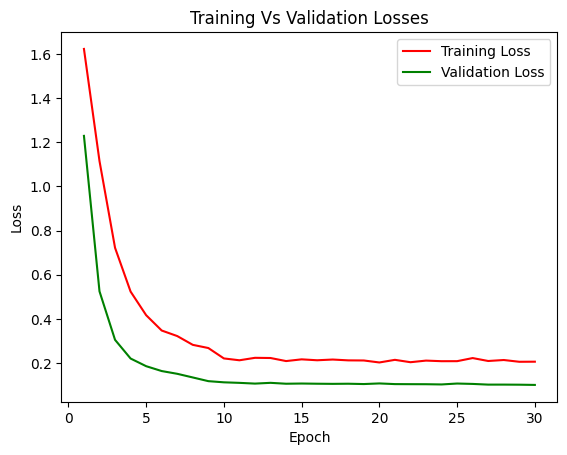

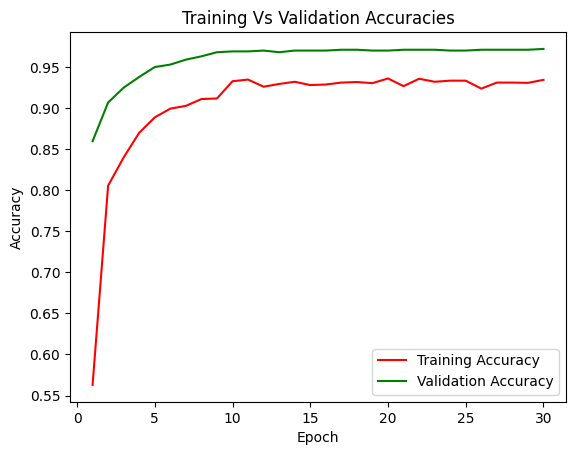

In [ ]:
lossModel_Train = []
lossModel_val = []
accModel_Train = []
accModel_val = []

file = open(WeightPath + 'lossTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_Train.append(float(element))

file = open(WeightPath + 'lossVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_val.append(float(element))

plt.figure()
plt.title("Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(range(1,len(lossModel_Train)+1)), lossModel_Train, color='r', label="Training Loss")
plt.plot(list(range(1, len(lossModel_val)+1)), lossModel_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig(WeightPath + 'LossTrainVal.png')

file = open(WeightPath + 'AccTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_Train.append(float(element))

file = open(WeightPath + 'AccVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_val.append(float(element))

plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(list(range(1, len(accModel_Train)+1)), accModel_Train, color='r', label="Training Accuracy")
plt.plot(list(range(1, len(accModel_val)+1)), accModel_val, color='g', label="Validation Accuracy")
plt.legend()
plt.savefig(WeightPath + 'AccTrainVal.png')

# Fase di Testing

In [ ]:
def test_model(model, dataloader, criterion):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            total_loss += loss.item() * inputs.size(0)

    accuracy = total_correct.double() / total_samples
    average_loss = total_loss / total_samples

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(f"Test Loss: {average_loss:.4f}")

# Controlla se esiste il test_dataloader, se non esiste lo sostituisce
test_dataloader = dataloaders['test']

# Funzione test_model
test_model(model_conv, test_dataloader, criterion)

Testing: 100%|██████████| 32/32 [00:56<00:00,  1.78s/it]


Test Accuracy: 0.9692
Test Loss: 0.1060


*Creazione e download del file CSV per submit mediante classificazione del codice*

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import csv
from google.colab import files

# Caricamento del modello addestrato
model_path = WeightPath + 'best_model_weights.pth'
checkpoint = torch.load(model_path)
#model_conv.load_state_dict(checkpoint['model_state_dict'])

# Verifica che la chiave 'state_dict' sia presente
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint

# Adatta le chiavi del dizionario in base alla struttura del modello
adjusted_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace('module.', '')  # Rimuove 'module.' se presente (dipende dalla modalità di salvataggio)
    adjusted_state_dict[new_key] = value

# Carica lo stato del modello
model_conv.load_state_dict(adjusted_state_dict)
model_conv.eval()

# Prepara le nuove immagini
new_images_path = '/content/TestSet'
new_images = [os.path.join(new_images_path, img) for img in os.listdir(new_images_path)]

# Applica le trasformazioni
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

# Lista dei risultati
results = []

# Classificazione
for img_path in new_images:
    img = Image.open(img_path).convert('RGB')
    img_tensor = data_transforms(img).unsqueeze(0)
    img_tensor = img_tensor.cuda()

    with torch.no_grad():
        output = model_conv(img_tensor)
        _, pred = torch.max(output, 1)
        class_name = class_names[pred.item()]

    # Estrazione del nome del file (senza percorso)
    file_name = os.path.basename(img_path)

    # Estrazione dell'indice numerico dal nome del file
    index = int(file_name.split('.')[0])

    # Estrazione dell'estensione dal nome del file
    extension = file_name.split('.')[-1]

    # Mapping del nome della classe rispeto la sua etichetta numerica
    class_label = {'CL': 0, 'BR': 1, 'DA': 2, 'RA': 3, 'SF': 4, 'SH': 5}[class_name]

    # Risultato aggiunto alla lista
    results.append({'rowID': f'{index}.{extension}', 'Class': class_label})

# Risultati ordinati in base alla colonna 'rowID'
results.sort(key=lambda x: int(x['rowID'].split('.')[0]))

# Risultati inseriti in un file CSV
csv_path = '/content/result_' + networkName + '.csv'
with open(csv_path, 'w', newline='') as csvfile:
    fieldnames = ['rowID', 'Class']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Intestazione
    writer.writeheader()

    # Dati
    writer.writerows(results)

print(f'I risultati sono stati scritti in: {csv_path}')

# Download file CSV
files.download(csv_path)

print(f'Il file csv è stato scaricato')

I risultati sono stati scritti in: /content/result_xception.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Il file csv è stato scaricato


*Download dei pesi in un .zip*

In [ ]:
import shutil
import os
from google.colab import files

# Percorso della cartella da zippare
folder_to_zip = '/content/pesi/' + networkName

# Archivio ZIP della cartella
shutil.make_archive(folder_to_zip, 'zip', folder_to_zip)

# Download file ZIP
zip_path = f'{folder_to_zip}.zip'
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>